In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## In SQL partition and rank example 1.0

In [ ]:
# We will attempt to rank the store category based on each individual category
# in SQL it is called a window function

'''
CREATE TABLE store_sales(
    store varchar(30),
    category varchar(30) NOT NULL,
    unit_sales bigint NOT NULL,
    CONSTRAINT store_category_key Primary KEY (store, category)
);

INSERT INTO store_sales (store, category, unit_sales)
VALUES
    ('Broders','Cereal',1104),
    ('Wallace','Ice Cream', 1863),
    ('Broders','Ice Cream',2517),
    ('Cramers','Ice Cream',2112),
    ('Broders','Beer',641),
    ('Cramers','Cereal',1003),
    ('Cramers','Beer',1003),
    ('Wallace','Cereal',980),
    ('Wallace','Beer',988);

SELECT
    category,
    store,
    unit_sales,
    rank() OVER (PARTITION BY category ORDER BY unit_sales DESC)
FROM store_sales;
'''

## In python, pandas example 1.0

In [2]:
data = [('Broders','Cereal',1104),
        ('Wallace','Ice Cream', 1863),
        ('Broders','Ice Cream',2517),
        ('Cramers','Ice Cream',2112),
        ('Broders','Beer',641),
        ('Cramers','Cereal',1003),
        ('Cramers','Beer',1003),
            ('Wallace','Cereal',980),
        ('Wallace','Beer',988)
        ]

df = pd.DataFrame(data,columns = ['store','category','unit_sales'])
print(df)
print('*'*40)
df['rank'] =df.groupby('category')['unit_sales'].rank(ascending = False)
print(df.sort_values(['category','rank'],ascending=True))

     store   category  unit_sales
0  Broders     Cereal        1104
1  Wallace  Ice Cream        1863
2  Broders  Ice Cream        2517
3  Cramers  Ice Cream        2112
4  Broders       Beer         641
5  Cramers     Cereal        1003
6  Cramers       Beer        1003
7  Wallace     Cereal         980
8  Wallace       Beer         988
****************************************
     store   category  unit_sales  rank
6  Cramers       Beer        1003   1.0
8  Wallace       Beer         988   2.0
4  Broders       Beer         641   3.0
0  Broders     Cereal        1104   1.0
5  Cramers     Cereal        1003   2.0
7  Wallace     Cereal         980   3.0
2  Broders  Ice Cream        2517   1.0
3  Cramers  Ice Cream        2112   2.0
1  Wallace  Ice Cream        1863   3.0


## Dealing with Timezone data, extracting hours from datetime column and aggregating SQL example 2.0

In [ ]:
# Aggregate timezones by trips in a per hour basis and count them
# Date is from The New York City Taxis and Limousine commission on 1st June 2016

'''
CREATE TABLE nyc_yellow_taxi_trips_2016_06_01 (
    trip_id bigserial PRIMARY KEY,
    vendor_id varchar(1) NOT NULL,
    tpep_pickup_datetime timestamp with time zone NOT NULL,
    tpep_dropoff_datetime timestamp with time zone NOT NULL,
    passenger_count integer NOT NULL,
    trip_distance numeric(8,2) NOT NULL,
    pickup_longitude numeric(18,15) NOT NULL,
    pickup_latitude numeric(18,15) NOT NULL,
    rate_code_id varchar(2) NOT NULL,
    store_and_fwd_flag varchar(1) NOT NULL,
    dropoff_longitude numeric(18,15) NOT NULL,
    dropoff_latitude numeric(18,15) NOT NULL,
    payment_type varchar(1) NOT NULL,
    fare_amount numeric(9,2) NOT NULL,
    extra numeric(9,2) NOT NULL,
    mta_tax numeric(5,2) NOT NULL,
    tip_amount numeric(9,2) NOT NULL,
    tolls_amount numeric(9,2) NOT NULL,
    improvement_surcharge numeric(9,2) NOT NULL,
    total_amount numeric(9,2) NOT NULL
);

COPY nyc_yellow_taxi_trips_2016_06_01 (
    vendor_id,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    passenger_count,
    trip_distance,
    pickup_longitude,
    pickup_latitude,
    rate_code_id,
    store_and_fwd_flag,
    dropoff_longitude,
    dropoff_latitude,
    payment_type,
    fare_amount,
    extra,
    mta_tax,
    tip_amount,
    tolls_amount,
    improvement_surcharge,
    total_amount
   )
FROM 'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_11\yellow_tripdata_2016_06_01.csv'
WITH (FORMAT CSV, HEADER, DELIMITER ',');

CREATE INDEX tpep_pickup_idx
ON nyc_yellow_taxi_trips_2016_06_01 (tpep_pickup_datetime);

SELECT 
    date_part('hour',tpep_pickup_datetime) AS trip_hour,
    COUNT(*)
FROM nyc_yellow_taxi_trips_2016_06_01
GROUP BY trip_hour
ORDER BY trip_hour;

'''

## Dealing with Timezone data, extracting hours from datetime column and aggregating Python example 2.0

In [3]:
timezone =  pd.read_csv(r'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_11\yellow_tripdata_2016_06_01.csv')

#Convert to datetime
print('current datetype:',timezone['tpep_pickup_datetime'].dtypes)
timezone['tpep_pickup_datetime'] = pd.to_datetime(timezone['tpep_pickup_datetime'])
print('After converting datetype:',timezone['tpep_pickup_datetime'].dtypes)

#Extract the hours from datetime column
timezone['trip_hour'] = timezone['tpep_pickup_datetime'].dt.hour

#
timezone.groupby('trip_hour')['vendor_id'] \
        .count() \
        .reset_index() \
        .rename(columns = {'vendor_id':'Hours of day'})

current datetype: object
After converting datetype: datetime64[ns, pytz.FixedOffset(-240)]


,trip_hour,Hours of day
0,0,8182
1,1,5003
2,2,3070
3,3,2275
4,4,2229
5,5,3925
6,6,10825
7,7,18287
8,8,21062
9,9,18975


Text(0.5, 1.0, 'Number of pickups per Hour of day \n on 1st June 2016')

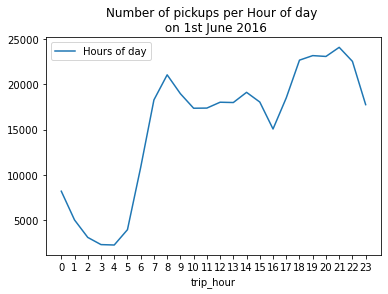

In [4]:
ax = timezone.groupby('trip_hour')['vendor_id'] \
        .count() \
        .reset_index() \
        .rename(columns = {'vendor_id':'Hours of day'}) \
        .plot \
        .line(x = 'trip_hour',y='Hours of day')
x = np.arange(0,24,1)
plt.xticks(x)

plt.title('Number of pickups per Hour of day \n on 1st June 2016')

## Joins with SQL example 3.0

In [ ]:
'''
CREATE TABLE schools_left (
    id integer CONSTRAINT left_id_key PRIMARY KEY,
    left_school varchar(30)
);

CREATE TABLE schools_right (
    id integer CONSTRAINT right_id_key PRIMARY KEY,
    right_school varchar(30)
);

INSERT INTO schools_left (id, left_school) VALUES
    (1, 'Oak Street School'),
    (2, 'Roosevelt High School'),
    (5, 'Washington Middle School'),
    (6, 'Jefferson High School');

INSERT INTO schools_right (id, right_school) VALUES
    (1, 'Oak Street School'),
    (2, 'Roosevelt High School'),
    (3, 'Morrison Elementary'),
    (4, 'Chase Magnet Academy'),
    (6, 'Jefferson High School');

SELECT *
FROM schools_left LEFT JOIN schools_right
ON schools_left.id = schools_right.id;

'''

## Joins with pandas example 3.0

In [5]:
left =  [(1, 'Oak Street School'),
        (2, 'Roosevelt High School'),
        (5, 'Washington Middle School'),
        (6, 'Jefferson High School')]

right = [    (1, 'Oak Street School'),
            (2, 'Roosevelt High School'),
            (3, 'Morrison Elementary'),
            (4, 'Chase Magnet Academy'),
            (6, 'Jefferson High School')]

schools_left = pd.DataFrame(left,columns = ['id','left_school'])
schools_right = pd.DataFrame(right,columns = ['id','right_school'])

#Left merge
merged = schools_left.merge(schools_right,how='left',on='id')

In [6]:
merged.head()

,id,left_school,right_school
0,1,Oak Street School,Oak Street School
1,2,Roosevelt High School,Roosevelt High School
2,5,Washington Middle School,NaN
3,6,Jefferson High School,Jefferson High School


## In SQL  Complex operation with a JOIN BETWEEN 2 DATASET example 4.0

In [ ]:
'''
SELECT 
	census.state_us_abbreviation AS st,
	census.st_population,
	plants.plant_count,
	round((plants.plant_count / census.st_population:: numeric(10,1))*1000000,1)
		AS plants_per_million
FROM
	(SELECT st,
	 count(*) AS plant_count
	 FROM meat_poultry_egg_inspect
	 GROUP BY st
	)
	AS plants
JOIN
   (SELECT state_us_abbreviation,
   		sum(p0010001) AS st_population
	FROM us_counties_2010
	GROUP BY state_us_abbreviation
   )
AS census

ON plants.st = census.state_us_abbreviation
ORDER BY plants_per_million DESC;
'''

## In Python Complex operation with a merge BETWEEN 2 DATASET example 4.0

In [7]:
census = pd.read_csv(r'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_04\us_counties_2010.csv')
plants =  pd.read_csv(r'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_09\MPI_Directory_by_Establishment_Name.csv')

In [8]:
#Start off with the plant query
plants_gp = plants.groupby('st')['est_number'] \
                  .count() \
                  .reset_index() \
                  .rename(columns = {'est_number':'plant_count'})

#census query
census_gp = census.groupby('STUSAB')['P0010001'] \
                  .sum() \
                  .reset_index() \
                  .rename(columns = {'P0010001':'st_population'})

print('snippet of plants_gp dataset')
print(plants_gp.head())
print('*'*40)
print('snippet of census_gp dataset')
print(census_gp.head())
print('*'*40)

#Inner Merged both
merged = plants_gp.merge(census_gp,left_on = 'st',right_on='STUSAB')
merged.head()

snippet of plants_gp dataset
   st  plant_count
0  AK           17
1  AL           93
2  AR           87
3  AS            1
4  AZ           37
****************************************
snippet of census_gp dataset
  STUSAB  st_population
0     AK         710231
1     AL        4779736
2     AR        2915918
3     AZ        6392017
4     CA       37253956
****************************************


,st,plant_count,STUSAB,st_population
0,AK,17,AK,710231
1,AL,93,AL,4779736
2,AR,87,AR,2915918
3,AZ,37,AZ,6392017
4,CA,666,CA,37253956


## Create sub grouping and count in SQL example 5.0

In [ ]:
'''
WITH temps_collapsed (station_name, max_temperature_group) AS
	(SELECT station_name,
		CASE WHEN max_temp >=  90 THEN 'Hot'
			 WHEN max_temp BETWEEN 70 and 89 THEN 'Warm'
		 	 WHEN max_temp BETWEEN 50 and 69 THEN 'Pleasant'
		 	 WHEN max_temp BETWEEN 33 and 49 THEN 'Cold'
		 	 WHEN max_temp BETWEEN 20 and 32 THEN 'Freezing'
	 	ELSE 'Inhumane'
	 END
FROM temperature_readings)

SELECT station_name,max_temperature_group, count(*)
FROM temps_collapsed
GROUP BY station_name,max_temperature_group
ORDER BY station_name,count(*) DESC ;
'''

##  Create sub grouping and count in python example 5.0

In [9]:
#Read in temperature dateframe
temps = pd.read_csv(r'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_12\temperature_readings.csv') \
        .rename(columns ={'STATION_NAME':'station_name','TMAX':'max_temp','TMIN':'min_temp'})
temps.head()

,station_name,DATE,max_temp,min_temp
0,CHICAGO NORTHERLY ISLAND IL US,20160101,31,20.0
1,CHICAGO NORTHERLY ISLAND IL US,20160102,34,23.0
2,CHICAGO NORTHERLY ISLAND IL US,20160103,32,26.0
3,CHICAGO NORTHERLY ISLAND IL US,20160104,32,27.0
4,CHICAGO NORTHERLY ISLAND IL US,20160105,34,20.0


In [10]:
temps['max_temperature_group'] = np.select([temps['max_temp']>=90,
                                             temps['max_temp'].between(70,89),
                                             temps['max_temp'].between(50,69),
                                             temps['max_temp'].between(33,49),
                                             temps['max_temp'].between(20,32)], #by default .between is inclusive
                                             ['Hot','Warm','Pleasant','Cold','Freezing'],
                                             'Inhumane') 

temps.groupby(['station_name','max_temperature_group'])['max_temp'].count()


station_name                    max_temperature_group
CHICAGO NORTHERLY ISLAND IL US  Cold                      92
                                Freezing                  30
                                Hot                        8
                                Inhumane                   8
                                Pleasant                  91
                                Warm                     133
SEATTLE BOEING FIELD WA US      Cold                      50
                                Hot                        3
                                Pleasant                 198
                                Warm                      98
WAIKIKI 717.2 HI US             Hot                        5
                                Warm                     361
Name: max_temp, dtype: int64

## Text-mining with regex SQL example 6.0


In [ ]:

'''
# Create the table in SQL

CREATE TABLE crime_reports (
	crime_id bigserial PRIMARY KEY,
	date_1 timestamp with time zone,
	date_2 timestamp with time zone,
	street varchar(250),
	city varchar(100),
	crime_type varchar(100),
	description text,
	case_number varchar(50),
	original_text text NOT NULL
);

COPY crime_reports(original_text)
FROM'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_13\crime_reports.csv'
WITH (FORMAT CSV, HEADER OFF, QUOTE '"');

# Slice the original_text column into the various columns with regex in the SQL table

UPDATE crime_reports
SET date_1 = 
(
	(regexp_match(original_text, '\d{1,2}\/\d{1,2}\/\d{2}'))[1]
	|| ' ' ||					  
	(regexp_match(original_text, '\/\d{2}\n(\d{4})'))[1]
	||' US/Eastern'				  
):: timestamptz,

date_2 = 
CASE 
    -- if there is no second date but there is a second hour
    WHEN (SELECT regexp_match(original_text, '-(\d{1,2}\/\d{1,2}\/\d{1,2})') IS NULL)
                     AND (SELECT regexp_match(original_text, '\/\d{2}\n\d{4}-(\d{4})') IS NOT NULL)
    THEN 
         ((regexp_match(original_text, '\d{1,2}\/\d{1,2}\/\d{2}'))[1]
              || ' ' ||
         (regexp_match(original_text, '\/\d{2}\n\d{4}-(\d{4})'))[1] 
              ||' US/Eastern'
          )::timestamptz 

    -- if there is both a second date and second hour
     WHEN (SELECT regexp_match(original_text, '-(\d{1,2}\/\d{1,2}\/\d{1,2})') IS NOT NULL)
              AND (SELECT regexp_match(original_text, '\/\d{2}\n\d{4}-(\d{4})') IS NOT NULL)
     THEN 
         ((regexp_match(original_text, '-(\d{1,2}\/\d{1,2}\/\d{1,2})'))[1]
              || ' ' ||
         (regexp_match(original_text, '\/\d{2}\n\d{4}-(\d{4})'))[1] 
              ||' US/Eastern'
          )::timestamptz 
    -- if neither of those conditions exist, provide a NULL
     ELSE NULL 
 END,
    street = (regexp_match(original_text, 'hrs.\n(\d+ .+(?:Sq.|Plz.|Dr.|Ter.|Rd.))'))[1],
    city = (regexp_match(original_text,
                           '(?:Sq.|Plz.|Dr.|Ter.|Rd.)\n(\w+ \w+|\w+)\n'))[1],
    crime_type = (regexp_match(original_text, '\n(?:\w+ \w+|\w+)\n(.*):'))[1],
    description = (regexp_match(original_text, ':\s(.+)(?:C0|SO)'))[1],
    case_number = (regexp_match(original_text, '(?:C0|SO)[0-9]+'))[1];


SELECT *
FROM crime_reports;


'''


## Text-mining with python example 6.0

In [11]:
crime_reports = (pd.read_csv(r'C:\Users\Alvin Ong\Practical SQL\practical-sql-master\practical-sql-master\Chapter_13\crime_reports.csv',
names = ['original_text'],header = None))

In [ ]:
crime_reports.head()
# personally felt that the SQL codes to extract the various columns with regex is quite lengthy, 
# lets try and decrease the number of syntax used with Python
# i do know we can do a str split here, but to follow through with the SQL codes, 
# i will also use regex to extract it into the various columns


# There are faster ways to do it with str.split, 
# but to follow the sql example above i will also use regex to extract it
# crime_reports['original_text'].str.split('\n',expand=True)

In [12]:
crime_reports =(crime_reports.assign 
    (date_1 = crime_reports['original_text'].str.extract('(\d{1,2}\/\d{1,2}\/\d{2})') + " "+ crime_reports['original_text'].str.extract('\n(\d{4})'),
     date_2 = crime_reports['original_text'].str.extract('-(\d{1,2}\/\d{1,2}\/\d{1,2})') + " "+ crime_reports['original_text'].str.extract('-(\d{4})'),
     street = crime_reports['original_text'].str.extract('hrs.\n(\d+ .+(?:Sq.|Plz.|Dr.|Ter.|Rd.))'),
     crime_type = crime_reports['original_text'].str.extract('\n(?:\w+ \w+|\w+)\n(.*):'),
     description = crime_reports['original_text'].str.extract('(?s):\s(.+)(?:C0|SO)'), #modified SQL regex from ':\s(.*)+(?:C0|SO)' to Python regex'(?s):\s(.+)(?!C0|SO)', 
                                                                                    #where (?s) will allow '.' to take in even line breaks
     case_number = crime_reports['original_text'].str.extract('(C0+\d+|SO+\d+)')   #change the syntax to make it work            

    )
                    )

#we are not done ! notice that date_2 (row 2) is missing a single value as the time given is 1400-1500 hrs
crime_reports['date_2'] = crime_reports['date_1'].astype(str).str.extract('(\d{1,2}\/\d{1,2}\/\d{2})')+" "+ crime_reports['original_text'].str.extract('-(\d{4})')

In [13]:
# Not forgetting to change date_1 and date_2 to US Eastern time !
crime_reports['date_1'] = pd.to_datetime(crime_reports['date_1'],dayfirst = True).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
crime_reports['date_2'] = pd.to_datetime(crime_reports['date_2'],dayfirst = True).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

In [14]:
# removing \n from the various string
crime_reports = crime_reports.replace(to_replace = {
                     'original_text':{'\n':' '},
                     'description':{'\n':' '},
                     },regex = True)

In [15]:
crime_reports

,original_text,date_1,date_2,street,crime_type,description,case_number
0,4/16/17-4/17/17 2100-0900 hrs. 46000 Block Ashmere Sq. Sterling Larceny: The victim reported that a bicycle was stolen from their opened garage door during the overnight hours. C0170006614,2017-04-16 17:00:00-04:00,2017-04-16 05:00:00-04:00,46000 Block Ashmere Sq.,Larceny,The victim reported that a bicycle was stolen from their opened garage door during the overnight hours.,C0170006614
1,4/8/17 1600 hrs. 46000 Block Potomac Run Plz. Sterling Destruction of Property: The victim reported that their vehicle was spray painted and the trim was ripped off while it was parked at this location. C0170006162,2017-08-04 12:00:00-04:00,NaT,46000 Block Potomac Run Plz.,Destruction of Property,The victim reported that their vehicle was spray painted and the trim was ripped off while it was parked at this location.,C0170006162
2,4/4/17 1400-1500 hrs. 24000 Block Hawthorn Thicket Ter. Sterling Larceny: The complainant reported that multiple windows were stolen from this home under construction. C0170006079,2017-04-04 10:00:00-04:00,2017-04-04 11:00:00-04:00,24000 Block Hawthorn Thicket Ter.,Larceny,The complainant reported that multiple windows were stolen from this home under construction.,C0170006079
3,04/10/17 1605 hrs. 21800 block Newlin Mill Rd. Middleburg Larceny: A license plate was reported stolen from a vehicle. SO170006250,2017-10-04 12:05:00-04:00,NaT,21800 block Newlin Mill Rd.,Larceny,A license plate was reported stolen from a vehicle.,SO170006250
4,04/09/17 1200 hrs. 470000 block Fairway Dr. Sterling Destruction of Property: Unknown subject(s) wrote graffiti on a sign in the area. SO170006211,2017-09-04 08:00:00-04:00,NaT,470000 block Fairway Dr.,Destruction of Property,Unknown subject(s) wrote graffiti on a sign in the area.,SO170006211
